In [1]:
%matplotlib inline
import os
os.environ['THEANO_FLAGS']='device=gpu0'

import tarfile
import matplotlib
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
import lasagne
import theano
import theano.tensor as T
conv = lasagne.layers.Conv2DLayer
pool = lasagne.layers.MaxPool2DLayer
NUM_EPOCHS = 15
BATCH_SIZE = 256
LEARNING_RATE = 0.001
DIM = 32
NUM_CLASSES = 10

theano.config.optimizer = 'fast_compile'
theano.config.exception_verbosity = 'high'


Using gpu device 0: GeForce GTX 750 Ti (CNMeM is disabled)


In [2]:
def unpickle(file):
    import cPickle
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

def load_data():
    
    

    if os.path.isdir("cifar1-10-batches-py") == False:
        print 'Downloading CIFAR-10 dataset...'
        !wget -N http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
        print 'Unzipping dataset...'
        t = tarfile.open('cifar-10-python.tar.gz', 'r')
        t.extractall('cifar-10')

    xs = []
    ys = []
    for j in range(5):
      d = unpickle('cifar-10/cifar-10-batches-py/data_batch_'+`j+1`)
      x = d['data']
      y = d['labels']
      xs.append(x)
      ys.append(y)

    d = unpickle('cifar-10/cifar-10-batches-py/test_batch')
    xs.append(d['data'])
    ys.append(d['labels'])

    x = np.concatenate(xs)/np.float32(255)
    y = np.concatenate(ys)

    x = np.dstack((x[:, :1024], x[:, 1024:2048], x[:, 2048:]))
    x = x.reshape((x.shape[0], 3, 32, 32))
    
    X_train=lasagne.utils.floatX(x[0:40000,:])
    X_valid = lasagne.utils.floatX(x[40001:50000,:])
    X_test = lasagne.utils.floatX(x[50001:60000,:])
    
    return dict(
        X_train=X_train,
        y_train=y[0:40000].astype('int32'),
        X_valid=X_valid,
        y_valid = y[40001:50000].astype('int32'),
        X_test=X_test,
        y_test = y[50001:60000].astype('int32'),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        num_examples_test=X_test.shape[0],
        input_height=X_train.shape[2],
        input_width=X_train.shape[3],
        output_dim=10,)
    
data = load_data()
print 'Loaded dataset'


--2015-11-05 13:24:22--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Server file no newer than local file ‘cifar-10-python.tar.gz’ -- not retrieving.

Unzipping dataset...
Loaded dataset


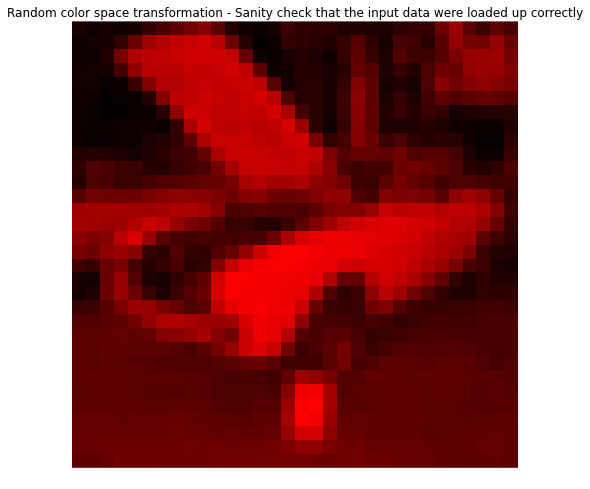

In [3]:
#Apply a random color space transformation on an input test image and display it for sanity check.
b = np.zeros((3, 3), dtype='float32')
b[0, 0] = 1
b[1, 1] = 0 
b[2, 2] = 0 

b = np.append(b,b)
    
W = b.flatten()
inputImages = data['X_test'][9997:10000]

num_batch, num_channels, height, width = inputImages.shape
W = T.reshape(W,(-1,3,3))

inputImages = T.reshape(inputImages,(num_batch, height, width, num_channels))
output = T.batched_dot(inputImages, W)


output = T.reshape(output,(num_batch, height, width, num_channels))


img = output[0,:,:,:].eval()
plt.figure(figsize=(8,8))
plt.imshow(img.reshape(DIM, DIM,3), interpolation='none')
plt.title('Random color space transformation - Sanity check that the input data were loaded up correctly')
plt.axis('off')
plt.show()


In [4]:
theano.config.floatX='float32'
from colortransformationlayer import ColorTransformationLayer

def build_model(input_width, input_height, output_dim,
                batch_size=BATCH_SIZE):
    ini = lasagne.init.GlorotUniform()

    inputs = lasagne.layers.InputLayer(shape=(None, 3, input_width, input_height),)

    # Color Space Transformation network
    b = np.zeros((3, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1 
    b[2, 2] = 1 

    
    b = b.flatten()
    tr_l1 = pool(inputs, pool_size=(2, 2))
    tr_l5 = lasagne.layers.DenseLayer(
        tr_l1, num_units=50, W=lasagne.init.HeUniform('relu'))
    tr_Color_net = lasagne.layers.DenseLayer(
        tr_l5, num_units=9, b=b, W=lasagne.init.Constant(0.0), 
        nonlinearity=lasagne.nonlinearities.identity)
    

    color_trans = ColorTransformationLayer([inputs, tr_Color_net])
    
        
    # Classification network
    class_l1 = conv(
        color_trans,
        num_filters=32,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )

    
    class_l2 = pool(class_l1, pool_size=(2, 2))

    class_l3 = conv(
        class_l2,
        num_filters=32,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )
    class_l4 = pool(class_l3, pool_size=(2, 2))

    
    class_l5 = lasagne.layers.DenseLayer(
        class_l4,
        num_units=256,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=ini,
    )

 
    # output layer
    network = lasagne.layers.DenseLayer(
        lasagne.layers.dropout(class_l5, p=.5),
        num_units=10,
        nonlinearity=lasagne.nonlinearities.softmax)
    

    return network, color_trans

model, color_transform = build_model(DIM, DIM, NUM_CLASSES)
model_params = lasagne.layers.get_all_params(model, trainable=True)

In [5]:
X = T.tensor4()
y = T.ivector()

# training output
output_train = lasagne.layers.get_output(model, X, deterministic=False)

# evaluation output. Also includes output of transform for plotting
output_eval, transform_eval = lasagne.layers.get_output([model, color_transform], X, deterministic=True)

sh_lr = theano.shared(lasagne.utils.floatX(LEARNING_RATE))
cost = T.mean(T.nnet.categorical_crossentropy(output_train, y))
updates = lasagne.updates.adam(cost, model_params, learning_rate=sh_lr)

train = theano.function([X, y], [cost, output_train], updates=updates,allow_input_downcast=True)
eval = theano.function([X], [output_eval, transform_eval],allow_input_downcast=True)

In [6]:
def train_epoch(X, y):
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    correct = 0
    for i in range(num_batches):
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        X_batch = X[idx]
        y_batch = y[idx]
        cost_batch, output_train = train(X_batch, y_batch)
        costs += [cost_batch]
        preds = np.argmax(output_train, axis=-1)
        correct += np.sum(y_batch == preds)

    return np.mean(costs), correct / float(num_samples)


def eval_epoch(X, y):
    output_eval, transform_eval = eval(X)
    preds = np.argmax(output_eval, axis=-1)
    acc = np.mean(preds == y)
    return acc, transform_eval

In [7]:


valid_accs, train_accs, test_accs = [], [], []
try:
    for n in range(NUM_EPOCHS):
        train_cost, train_acc = train_epoch(data['X_train'], data['y_train'])
        valid_acc, valid_transform = eval_epoch(data['X_valid'], data['y_valid'])
        test_acc, test_transform = eval_epoch(data['X_test'], data['y_test'])
        valid_accs += [valid_acc]
        test_accs += [test_acc]
        train_accs += [train_acc]



        if (n+1) % 20 == 0:
            new_lr = sh_lr.get_value() * 0.7
            print "New LR:", new_lr
            sh_lr.set_value(lasagne.utils.floatX(new_lr))
          
        print "Epoch {0}: Train cost {1}, Train acc {2}, val acc {3}, test acc {4}".format(
                n, train_cost, train_acc, valid_acc, test_acc)
except KeyboardInterrupt:
    pass

Epoch 0: Train cost 1.7622770071, Train acc 0.35535, val acc 0.451445144514, test acc 0.45804580458
Epoch 1: Train cost 1.45892131329, Train acc 0.47675, val acc 0.493349334933, test acc 0.493949394939
Epoch 2: Train cost 1.32146942616, Train acc 0.5319, val acc 0.5499549955, test acc 0.550655065507
Epoch 3: Train cost 1.23233950138, Train acc 0.565225, val acc 0.589558955896, test acc 0.590459045905
Epoch 4: Train cost 1.14076411724, Train acc 0.598525, val acc 0.609860986099, test acc 0.610461046105
Epoch 5: Train cost 1.09942936897, Train acc 0.6102, val acc 0.638563856386, test acc 0.642764276428
Epoch 6: Train cost 1.04031431675, Train acc 0.63605, val acc 0.646864686469, test acc 0.644564456446
Epoch 7: Train cost 0.98349404335, Train acc 0.65415, val acc 0.649364936494, test acc 0.649564956496
Epoch 8: Train cost 0.945042014122, Train acc 0.6684, val acc 0.656365636564, test acc 0.6599659966
Epoch 9: Train cost 0.902434408665, Train acc 0.680225, val acc 0.667666766677, test acc

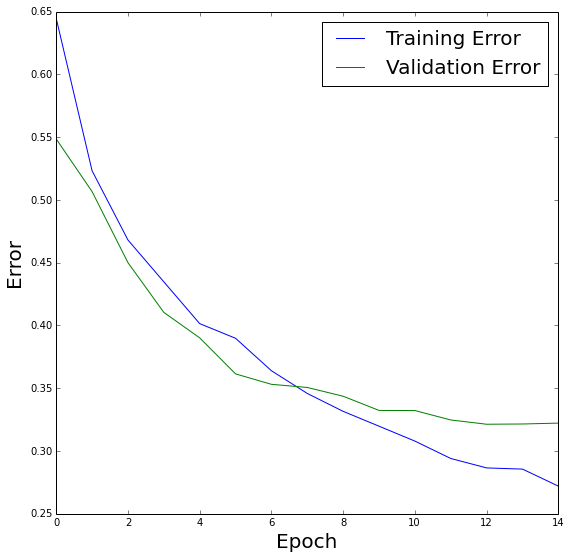

In [8]:
plt.figure(figsize=(9,9))
plt.plot(1-np.array(train_accs), label='Training Error')
plt.plot(1-np.array(valid_accs), label='Validation Error')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Error', fontsize=20)
plt.show()

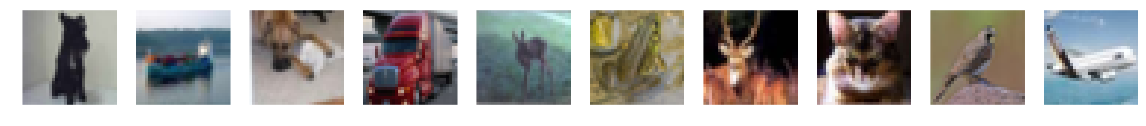

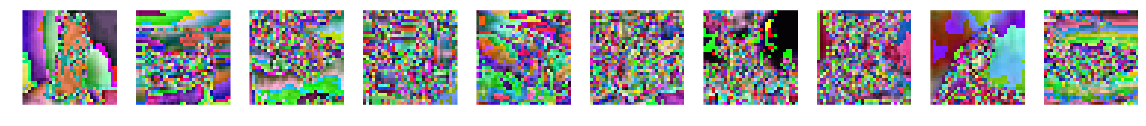

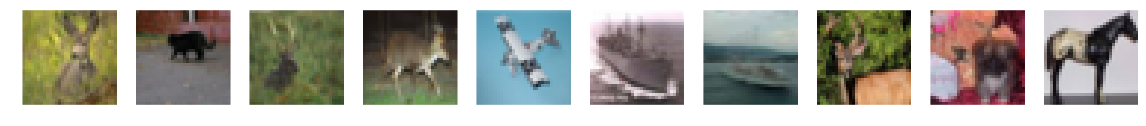

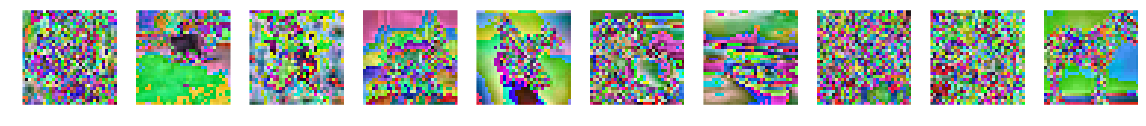

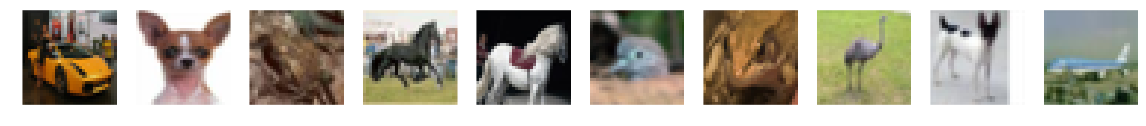

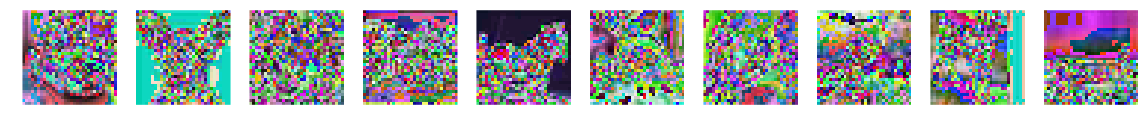

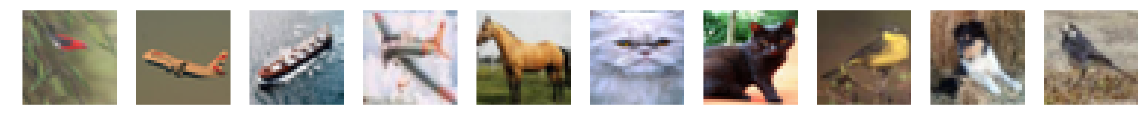

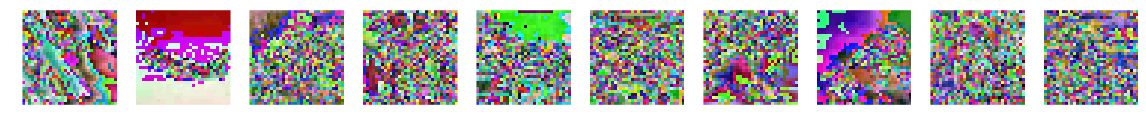

In [10]:
#Show some example images along with their color transformed counterparts

import matplotlib.pyplot as plt


plt.figure(figsize=(20,20))
k = 550
num_images = 10
for i in range(num_images):
    testImage = data['X_test'][i+k]
    plt.subplot(2,num_images,i+1)
    plt.imshow(testImage.reshape(DIM, DIM,3),interpolation='none')
    plt.axis('off')
    
plt.figure(figsize=(20,20))
for i in range(num_images):
    trans_Image = test_transform[i+k]
    plt.subplot(2,num_images,i+1)
    plt.imshow(trans_Image.transpose(1,2,0),interpolation='none')
    plt.axis('off')

plt.figure(figsize=(20,20))
k = 1550
num_images = 10
for i in range(num_images):
    testImage = data['X_test'][i+k]
    plt.subplot(2,num_images,i+1)
    plt.imshow(testImage.reshape(DIM, DIM,3),interpolation='none')
    plt.axis('off')
    
plt.figure(figsize=(20,20))
for i in range(num_images):
    trans_Image = test_transform[i+k]
    plt.subplot(2,num_images,i+1)
    plt.imshow(trans_Image.transpose(1,2,0),interpolation='none')
    plt.axis('off')
plt.show()


plt.figure(figsize=(20,20))
k = 1750
num_images = 10
for i in range(num_images):
    testImage = data['X_test'][i+k]
    plt.subplot(2,num_images,i+1)
    plt.imshow(testImage.reshape(DIM, DIM,3),interpolation='none')
    plt.axis('off')
    
plt.figure(figsize=(20,20))
for i in range(num_images):
    trans_Image = test_transform[i+k]
    plt.subplot(2,num_images,i+1)
    plt.imshow(trans_Image.transpose(1,2,0),interpolation='none')
    plt.axis('off')

plt.figure(figsize=(20,20))
k = 4100
num_images = 10
for i in range(num_images):
    testImage = data['X_test'][i+k]
    plt.subplot(2,num_images,i+1)
    plt.imshow(testImage.reshape(DIM, DIM,3),interpolation='none')
    plt.axis('off')
    
plt.figure(figsize=(20,20))
for i in range(num_images):
    trans_Image = test_transform[i+k]
    plt.subplot(2,num_images,i+1)
    plt.imshow(trans_Image.transpose(1,2,0),interpolation='none')
    plt.axis('off')
plt.show()

 